Step 1: Upload CSV

In [ ]:
import pandas as pd

data = pd.read_csv('weatherHistory.csv')
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], utc=True)
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


Step 2: Feature Selection for ML

In [ ]:
features_ml = [
    'Apparent Temperature (C)',
    'Humidity',
    'Wind Speed (km/h)',
    'Wind Bearing (degrees)',
    'Visibility (km)',
    'Loud Cover',
    'Pressure (millibars)'
]


data['Precip Type'] = data['Precip Type'].fillna('rain')
data['Precip Type'] = data['Precip Type'].map({'rain':0, 'snow':1})

features_ml.append('Precip Type')

X_ml = data[features_ml]
y_ml = data['Temperature (C)']

# Filling the  missing values
X_ml.fillna(X_ml.median(), inplace=True)
y_ml.fillna(y_ml.median(), inplace=True)


/tmp/ipython-input-3279695722.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_ml.fillna(X_ml.median(), inplace=True)


Step 3: Add Time Features

In [ ]:
data['Hour'] = data['Formatted Date'].dt.hour
data['Day'] = data['Formatted Date'].dt.day
data['Month'] = data['Formatted Date'].dt.month
data['Year'] = data['Formatted Date'].dt.year
data['Weekday'] = data['Formatted Date'].dt.weekday

X_ml['Hour'] = data['Hour']
X_ml['Day'] = data['Day']
X_ml['Month'] = data['Month']
X_ml['Year'] = data['Year']
X_ml['Weekday'] = data['Weekday']


Step 4: Scale & Split

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler_ml = StandardScaler()
X_ml_scaled = scaler_ml.fit_transform(X_ml)

X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(
    X_ml_scaled, y_ml, test_size=0.2, random_state=42
)


Step 5: ML Model Training

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Random Forest
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf.fit(X_train_ml, y_train_ml)
rf_pred = rf.predict(X_test_ml)

# XGBoost
xgb = XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42)
xgb.fit(X_train_ml, y_train_ml)
xgb_pred = xgb.predict(X_test_ml)


In [ ]:
# Evaluating ml models
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test_ml, rf_pred)))
print("Random Forest MSE:", mean_squared_error(y_test_ml, rf_pred))
print("Random Forest MAE:", mean_absolute_error(y_test_ml, rf_pred))
print("")
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test_ml, xgb_pred)))
print("XGBoost Forest MSE:", mean_squared_error(y_test_ml, xgb_pred))
print("XGBOOST Forest MAE:", mean_absolute_error(y_test_ml, xgb_pred))


Random Forest RMSE: 0.09008270385294488
Random Forest MSE: 0.008114893533457372
Random Forest MAE: 0.04350340969959164

XGBoost RMSE: 0.1425346440635365
XGBoost Forest MSE: 0.02031612475831904
XGBOOST Forest MAE: 0.06722504637367668


Step 6: Prepare LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

temp_data = data[['Temperature (C)']].values
scaler_lstm = MinMaxScaler(feature_range=(0,1))
scaled_temp = scaler_lstm.fit_transform(temp_data)

SEQ_LENGTH = 30
X_lstm, y_lstm = [], []
for i in range(SEQ_LENGTH, len(scaled_temp)):
    X_lstm.append(scaled_temp[i-SEQ_LENGTH:i,0])
    y_lstm.append(scaled_temp[i,0])

X_lstm = np.array(X_lstm).reshape(-1, SEQ_LENGTH, 1)
y_lstm = np.array(y_lstm)

split = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]


Step 6: Build & Train LSTM

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH,1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.summary()

history = model_lstm.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32,
                         validation_data=(X_test_lstm, y_test_lstm))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 78s 31ms/step - loss: 0.0088 - val_loss: 7.3520e-04
Epoch 2/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 80s 30ms/step - loss: 0.0014 - val_loss: 3.7406e-04
Epoch 3/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 73s 30ms/step - loss: 7.9345e-04 - val_loss: 3.3238e-04
Epoch 4/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 73s 30ms/step - loss: 7.1984e-04 - val_loss: 3.1736e-04
Epoch 5/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 73s 30ms/step - loss: 7.1973e-04 - val_loss: 3.2455e-04
Epoch 6/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 71s 30ms/step - loss: 7.2455e-04 - val_loss: 3.9619e-04
Epoch 7/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 71s 29ms/step - loss: 7.0078e-04 - val_loss: 3.2939e-04
Epoch 8/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 87s 32ms/step - loss: 7.0265e-04 - val_loss: 3.2745e-04
Epoch 9/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 73s 30ms/step - loss: 6.8248e-04 - val_loss: 3.2077e-04
Epoch 10/50
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 72s 30ms/step - loss: 6.8500e-04 - val_loss: 3.0920e-04
Epoch 11/50
2411/2411 ━━━━━

Step 7: Evaluate LSTM

603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step
LSTM RMSE: 1.0947457942920857


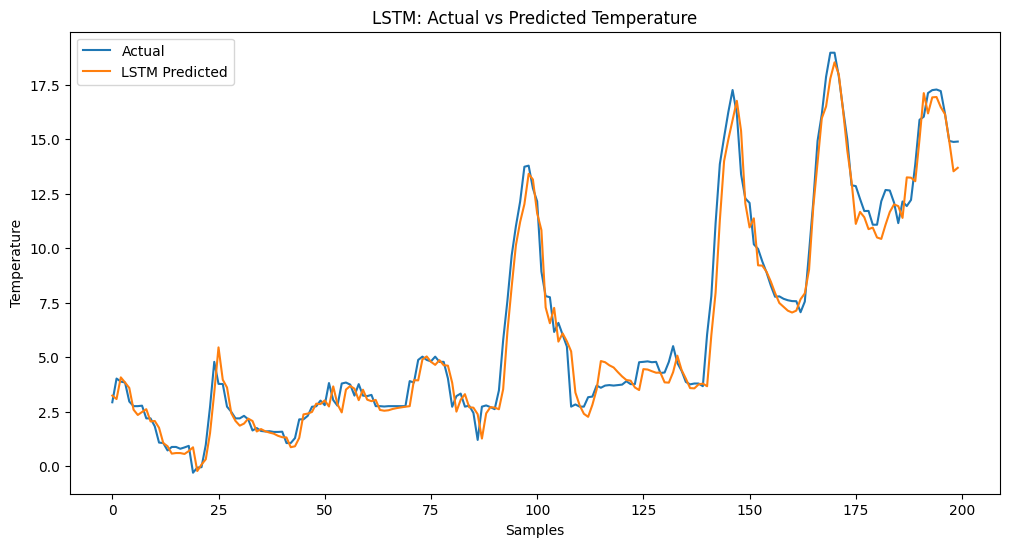

In [ ]:
y_pred_lstm = model_lstm.predict(X_test_lstm)
y_test_inv = scaler_lstm.inverse_transform(y_test_lstm.reshape(-1,1))
y_pred_inv = scaler_lstm.inverse_transform(y_pred_lstm)

rmse_lstm = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print("LSTM RMSE:", rmse_lstm)

# Ploting predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(y_test_inv[:200], label='Actual')
plt.plot(y_pred_inv[:200], label='LSTM Predicted')
plt.title("LSTM: Actual vs Predicted Temperature")
plt.xlabel("Samples")
plt.ylabel("Temperature")
plt.legend()
plt.show()


Step 8: Compare ML vs LSTM

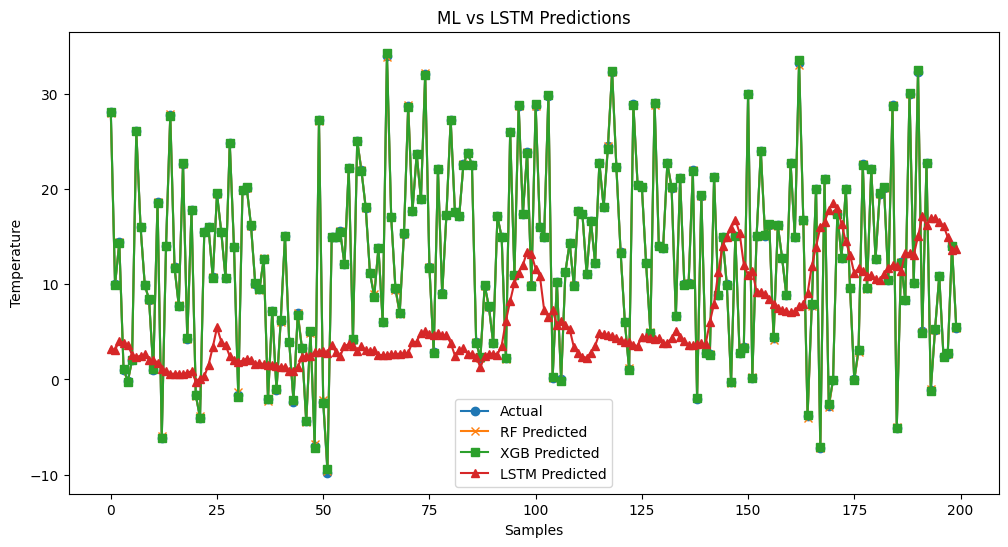

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_ml.values[:200], label='Actual', marker='o')
plt.plot(rf_pred[:200], label='RF Predicted', marker='x')
plt.plot(xgb_pred[:200], label='XGB Predicted', marker='s')
plt.plot(y_pred_inv[:200], label='LSTM Predicted', marker='^')
plt.title("ML vs LSTM Predictions")
plt.xlabel("Samples")
plt.ylabel("Temperature")
plt.legend()
plt.show()


Step 9: Save Models

In [ ]:
import joblib

# Save ML models
joblib.dump(rf, 'rf_model.pkl')
joblib.dump(xgb, 'xgb_model.pkl')
joblib.dump(scaler_ml, 'scaler_ml.pkl')
joblib.dump(scaler_lstm, 'scaler_lstm.pkl')

# Save LSTM model
model_lstm.save('lstm_model.h5')


In [ ]:
!pwd



/content


In [ ]:
!ls

lstm_model.h5  sample_data	scaler_ml.pkl	    xgb_model.pkl
rf_model.pkl   scaler_lstm.pkl	weatherHistory.csv


In [ ]:
from google.colab import files

files.download('rf_model.pkl')
files.download('xgb_model.pkl')
files.download('scaler_ml.pkl')
files.download('scaler_lstm.pkl')
files.download('lstm_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

PREDICTNG by values

In [49]:
import joblib
import tensorflow as tf

# Load ML models
rf_model = joblib.load('rf_model.pkl')
xgb_model = joblib.load('xgb_model.pkl')
scaler_ml = joblib.load('scaler_ml.pkl')
scaler_lstm = joblib.load('scaler_lstm.pkl')

# Load LSTM model
lstm_model = tf.keras.models.load_model('lstm_model.h5')


In [46]:

# Format: [Apparent Temp, Humidity, Wind Speed, Wind Bearing, Visibility, Loud Cover, Pressure, Precip Type, Hour, Day, Month, Year, Weekday]

# Give your manual input here
manual_input = [10.0, 0.5, 12.0, 180.0, 10.0, 5.0, 1013.0, 0, 14, 23, 10, 2025, 3]  # Example values

# Scale the input
X_input_scaled = scaler_ml.transform([manual_input])


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [47]:
# Random Forest prediction
rf_pred = rf_model.predict(X_input_scaled)[0]

# XGBoost prediction
xgb_pred = xgb_model.predict(X_input_scaled)[0]

print(f"Random Forest Prediction: {rf_pred:.2f} °C")
print(f"XGBoost Prediction: {xgb_pred:.2f} °C")


Random Forest Prediction: 10.00 °C
XGBoost Prediction: 10.06 °C


FOR LSTM

In [48]:
# Example last 30 days temperatures
last_30_days = [10, 12, 11, 13, 12, 14, 13, 12, 11, 10, 12, 11, 13, 12, 14,
                13, 12, 11, 10, 12, 11, 13, 12, 14, 13, 12, 11, 10, 12, 11]

# Scale input
lstm_input_scaled = scaler_lstm.transform(np.array(last_30_days).reshape(-1,1))
lstm_input_scaled = lstm_input_scaled.reshape(1,30,1)

# Predict next day temperature
lstm_pred_scaled = lstm_model.predict(lstm_input_scaled)
lstm_pred = scaler_lstm.inverse_transform(lstm_pred_scaled)
print(f"LSTM Predicted Temperature (next day): {lstm_pred[0][0]:.2f} °C")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
LSTM Predicted Temperature (next day): 11.00 °C
